## Import Libraries


In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time
from google.colab import files

import sklearn 
from sklearn import kernel_ridge
from sklearn import ensemble
from sklearn import tree
from sklearn import preprocessing 
from sklearn import feature_extraction
from sklearn.model_selection import RandomizedSearchCV
from sklearn import decomposition
from sklearn import pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import neural_network
import scipy.stats as stats


## Fetch Regression Data from our GitHub repository

In [4]:
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_X_train.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_X_test.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_y_train.csv
!wget -c https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_y_test.csv

--2020-12-01 21:52:53--  https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_X_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 710356 (694K) [text/plain]
Saving to: ‘regression_X_train.csv’

regression_X_train. 100%[===================>] 693.71K  --.-KB/s    in 0.03s   

2020-12-01 21:52:54 (25.1 MB/s) - ‘regression_X_train.csv’ saved [710356/710356]

--2020-12-01 21:52:54--  https://raw.githubusercontent.com/KyleRoss-rice/SignIconicityPredictor/main/data/regression_data/regression_X_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... 

## Create working datasets

### Create ndarrays from csv files

In [5]:
X_train_source = np.loadtxt("regression_X_train.csv", skiprows=1, delimiter=',').astype('float32')
X_test_source = np.loadtxt("regression_X_test.csv", skiprows=1, delimiter=',').astype('float32')

y_train_source = np.loadtxt("regression_y_train.csv", skiprows=1, delimiter=',').astype('float32')
y_test_source = np.loadtxt("regression_y_test.csv", skiprows=1, delimiter=',').astype('float32')

In [6]:
random_state = 0
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X_train_source, y_train_source, test_size=0.2)

X_train_ID = X_train[:,0]
X_validation_ID = X_validation[:,0]
X_test_ID = X_test_source[:,0]

X_train = X_train[:,1:]
X_validation = X_validation[:,1:]
X_test = X_test_source[:,1:]

y_train_SD = y_train[:,1]
y_validation_SD = y_validation[:,1]
y_test_SD = y_test_source[:,1]
y_train = y_train[:,0]
y_validation = y_validation[:,0]
y_test = y_test_source[:,0]

### Preprocess the input data

In [7]:
X_train = sklearn.preprocessing.StandardScaler().fit_transform(X_train) 
X_validation = sklearn.preprocessing.StandardScaler().fit_transform(X_validation) 
X_test = sklearn.preprocessing.StandardScaler().fit_transform(X_test) 

## Sanity check with a dummy regressor

In [8]:
dummy_model = sklearn.dummy.DummyRegressor(strategy='mean').fit(X_train, y_train)
dummy_score = dummy_model.score(X_validation, y_validation);
np.testing.assert_almost_equal(dummy_score, 0, decimal=3)
print(f'Dummy score for the mean is {dummy_score}; It is close enough to desired value of 0')

Dummy score for the mean is -0.00021211984237790027; It is close enough to desired value of 0


## Custom scoring function

In [9]:
def score_within_sd(predictions, gt_ir, gt_ir_sd):
  distances = abs(predictions - gt_ir) 
  n_errors = np.count_nonzero(distances > gt_ir_sd)

  return 1 - n_errors / len(predictions)

In [10]:
scoring_methods = ('MAE Train', 'MAE Val', 'MSE Train', 'MSE Val', 'R2 Train', 'R2 Val', 'Custom Train', 'Custom Val')
scoring_titles = ('Best MAE Train', 'Best MAE Val', 'Best MSE Train', 'Best MSE Val', 'Best R2 Train', 'Best R2 Val', 'Best Custom Train', 'Best Custom Val')

##TODO: This function is ugly and doesn't scale nicely to adding new scores
def get_scores(models, model_names):
  scores = []
  names = [None] * len(scoring_methods)
  best_mae_train = math.inf
  best_mae_test = math.inf
  best_mse_train = math.inf
  best_mse_test = math.inf
  best_r2_train = -math.inf
  best_r2_test = -math.inf
  best_custom_train = 0
  best_custom_test = 0

  for i, m in enumerate(models):
    predictions_train = m.predict(X_train_pca)
    predictions_test = m.predict(X_validation_pca)

    mae_train = sklearn.metrics.mean_absolute_error(y_train, predictions_train)
    if mae_train < best_mae_train:
      best_mae_train = mae_train
      names[0] = model_names[i]

    mae_test = sklearn.metrics.mean_absolute_error(y_validation, predictions_test)
    if mae_test < best_mae_test:
      best_mae_test = mae_test
      names[1] = model_names[i]

    mse_train = sklearn.metrics.mean_squared_error(y_train, predictions_train)
    if mse_train < best_mse_train:
      best_mse_train = mse_train
      names[2] = model_names[i]

    mse_test = sklearn.metrics.mean_squared_error(y_validation, predictions_test)
    if mse_test < best_mse_test:
      best_mse_test = mse_test
      names[3] = model_names[i]

    r2_train = sklearn.metrics.r2_score(y_train, predictions_train)
    if r2_train > best_r2_train:
      best_r2_train = r2_train
      names[4] = model_names[i]

    r2_test = sklearn.metrics.r2_score(y_validation, predictions_test)
    if r2_test > best_r2_test:
      best_r2_test = r2_test
      names[5] = model_names[i]

    custom_train = score_within_sd(predictions_train, y_train, y_train_SD)
    if custom_train > best_custom_train:
      best_custom_train = custom_train
      names[6] = model_names[i]

    custom_test = score_within_sd(predictions_test, y_validation, y_validation_SD)
    if custom_test > best_custom_test:
      best_custom_test = custom_test 
      names[7] = model_names[i]
    
    scores.append((mae_train, mae_test, mse_train, mse_test, r2_train, r2_test, custom_train, custom_test))

  return scores, ((names[0], best_mae_train),
                  (names[1], best_mae_test),
                  (names[2], best_mse_train),
                  (names[3], best_mse_test),
                  (names[4], best_r2_train),
                  (names[5], best_r2_test),
                  (names[6], best_custom_train),
                  (names[7], best_custom_test))

## PCA
Based on https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

In [11]:
explained_variance_targets = (0.95, 0.99)
pcas = []

for e in explained_variance_targets:
  pcas.append(sklearn.decomposition.PCA(e, random_state=random_state).fit(X_train))

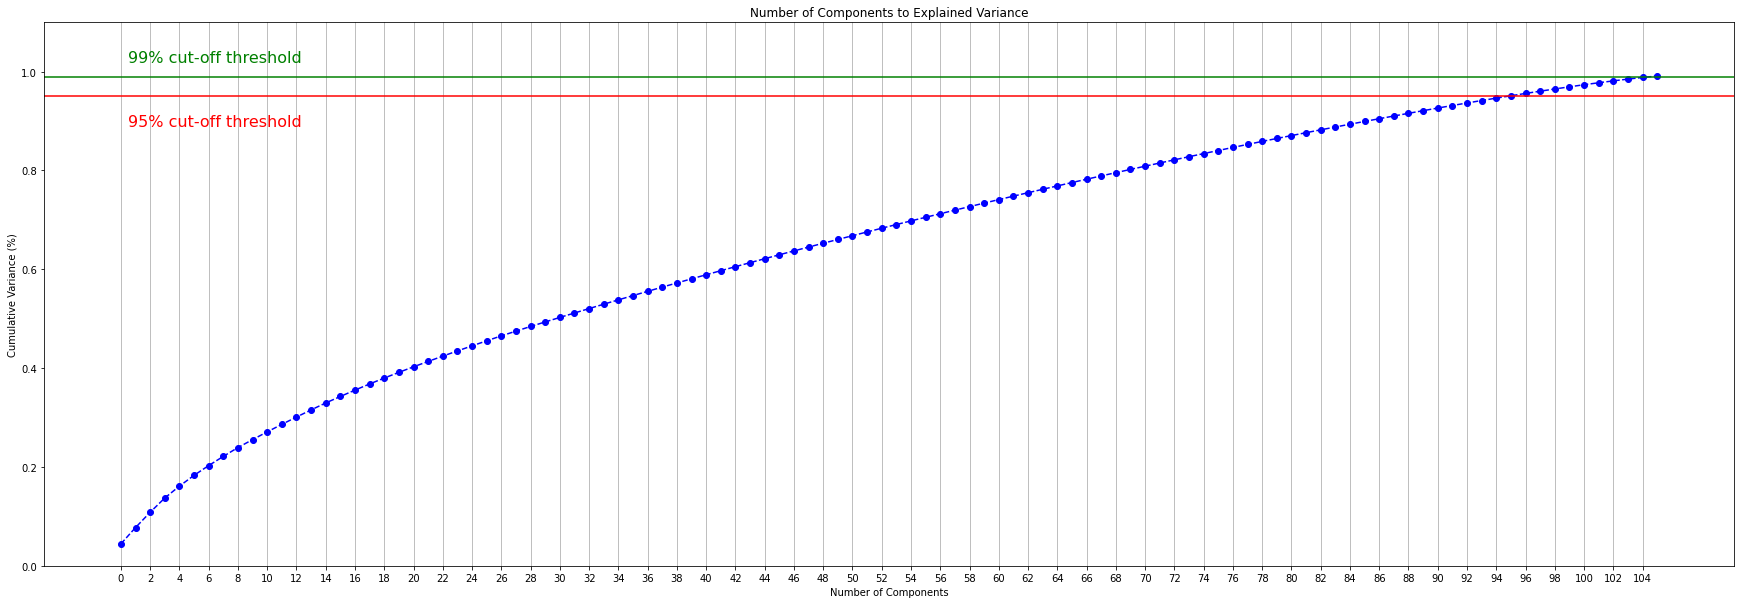

In [12]:
pca = pcas[-1]
explained_variance_ratio = pca.explained_variance_ratio_
n_pca_components = len(pca.components_)

plt.figure(figsize=(n_pca_components / 3.5, 10))
x = np.arange(0, n_pca_components, step=1)
y = np.cumsum(explained_variance_ratio)

plt.ylim(0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_pca_components, step=2)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)')
plt.title('Number of Components to Explained Variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.89, '95% cut-off threshold', color = 'r', fontsize=16)
plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 1.02, '99% cut-off threshold', color = 'g', fontsize=16)

plt.grid(axis='x')

## Model Selection

##Selecting an estimator 


In [13]:
model_names = []
models = []

X_train_pca = pca.transform(X_train)
X_validation_pca = pca.transform(X_validation)
X_test_pca = pca.transform(X_test)

#### SVR

In [14]:
kernel_list = ['rbf', 'poly', 'linear', 'sigmoid']

for k in kernel_list:
  models.append(sklearn.svm.SVR(kernel=k, epsilon=1).fit(X_train_pca, y_train))
  model_names.append('SVR ' + k)

#### Kernel Ridge

In [15]:
kernel_list.append('laplacian')

for k in kernel_list:
  models.append(sklearn.kernel_ridge.KernelRidge(kernel=k).fit(X_train_pca, y_train))
  model_names.append('Kernel Ridge ' + k)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


#### Decision Tree Regressor

In [16]:
criteria=['mae','mse']

for c in criteria:
  models.append(sklearn.tree.DecisionTreeRegressor(criterion=c, random_state=random_state).fit(X_train_pca, y_train))
  model_names.append('DTree ' + c)

#### Random Forest

In [ ]:
for c in criteria:
  models.append(sklearn.ensemble.RandomForestRegressor(criterion=c, random_state=random_state).fit(X_train_pca, y_train))
  model_names.append('RForest ' + c)

#### MLP

In [ ]:
activate=['logistic', 'tanh', 'relu']

for a in activate:
  models.append(sklearn.neural_network.MLPRegressor(max_iter=2000, hidden_layer_sizes=(128), activation=a, random_state=random_state).fit(X_train_pca, y_train))
  model_names.append('sklearn MLP ' + a)

#### Compute scores

In [ ]:
scores, bests = get_scores(models, model_names)

In [ ]:
bests_df = pd.DataFrame(bests, index=scoring_titles, columns=('Estimator', 'Score'))
bests_df

In [ ]:
scores_df = pd.DataFrame(scores, index = model_names, columns = scoring_methods)
scores_df

### Neural Network with Custom Loss Function

In [ ]:
torch.manual_seed(random_state)
class RegressionMLP(torch.nn.Module):
  def __init__(self, n_features, n_hidden_layer):
    super(RegressionMLP, self).__init__()
    self.hidden = torch.nn.Linear(n_features, n_hidden_layer)
    self.predict = torch.nn.Linear(n_hidden_layer, 1)
  
  def forward(self, x):
    x = torch.tanh(self.hidden(x)).cuda()
    x = self.predict(x).cuda()
    return x

In [ ]:
def customLoss(predictions, targets, targets_sd):
  distances = torch.abs(predictions - targets).cuda()
  not_within_one_sd = (distances > targets_sd).cuda()
  transform = (1**(not_within_one_sd * 10)).cuda()
  distances *= transform.cuda()

  return torch.sum(distances) / len(predictions) 

In [ ]:
def customLoss2(predictions, targets, targets_sd):
  distances = torch.abs(predictions - targets).cuda()
  not_within_one_sd = (distances > targets_sd).cuda()
  transform = (1**(not_within_one_sd * 10)).cuda()
  distances *= transform.cuda()
  distances @= distances.T

  return 1/2 * torch.sum(distances) / len(predictions) 

In [ ]:
model = RegressionMLP(n_pca_components, 128).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = customLoss
model.train()
inputs = torch.from_numpy(X_train_pca).cuda()
training_targets = torch.from_numpy(y_train)
training_targets = training_targets.view(-1, 1).cuda()
trainig_targets_sd = torch.from_numpy(y_train_SD)
training_targets_sd = training_targets_sd.view(-1, 1).cuda()

validation_inputs = torch.from_numpy(X_validation_pca).cuda()
validation_targets = torch.from_numpy(y_validation)
validation_targets = validation_targets.view(-1, 1).cuda()
validation_targets_sd = torch.from_numpy(y_validation_SD)
validation_targets_sd = validation_targets_sd.view(-1, 1).cuda()

In [ ]:
n_epochs = 7000
training_loss = [None] * n_epochs
validation_loss = [None] * n_epochs

tic = time.perf_counter()
for i in range(n_epochs):
  predictions = model(inputs)
  optimizer.zero_grad()
  loss = loss_func(predictions, targets, targets_sd)
  loss.backward()
  training_loss[i] = loss.item()
  val = loss_func(model(validation_inputs), validation_targets, validation_targets_sd)
  validation_loss[i] = val.item()
  optimizer.step()
print(f'time: {time.perf_counter() - tic}')

In [ ]:
model.eval()
training_predictions = model(torch.from_numpy(X_train_pca).cuda())
training_predictions = training_predictions.cpu().detach().numpy()

validation_predictions = model(torch.from_numpy(X_validation_pca).cuda())
validation_predictions = validation_predictions.cpu().detach().numpy()

In [ ]:
x = np.linspace(0, n_epochs, n_epochs)
plt.figure(figsize=(20,10))
plt.plot(x, training_loss, label='training loss')
plt.plot(x, testing_loss, label='validation loss')
best_epoch = np.array(validation_loss).argmin()
best_epoch_loss = validation_loss[best_epoch]
plt.scatter(best_epoch, best_epoch_loss, marker='x', c='r')
plt.text(best_epoch, best_epoch_loss + 0.1, s=f'best epoch: {best_epoch}')
plt.legend();

In [ ]:
n_epochs = best_epoch + 1
model.train()
tic = time.perf_counter()
for i in range(n_epochs):
  predictions = model(inputs)
  optimizer.zero_grad()
  loss = loss_func(predictions, targets, targets_sd)
  loss.backward()
  optimizer.step()
print(f'time: {time.perf_counter() - tic}')

In [ ]:
model.eval()
training_predictions = model(torch.from_numpy(X_train_pca).cuda())
training_predictions = training_predictions.cpu().detach().numpy().reshape(-1)

validation_predictions = model(torch.from_numpy(X_validation_pca).cuda())
validation_predictions = testing_predictions.cpu().detach().numpy().reshape(-1)

testing_predictions = model(torch.from_numpy(X_test_pca).cuda())
testing_predictions = testing_predictions2.cpu().detach().numpy().reshape(-1)

In [ ]:
print('Custom Score Train-Validation-Testing')
print(score_within_sd(training_predictions, y_train, y_train_SD))
print(score_within_sd(validation_predictions, y_validation, y_validation_SD))
print(score_within_sd(testing_predictions, y_test, y_test_SD))

print('MAE Score Train-Validation-Testing')
print(sklearn.metrics.mean_absolute_error(training_predictions, y_train))
print(sklearn.metrics.mean_absolute_error(validation_predictions, y_validation))
print(sklearn.metrics.mean_absolute_error(testing_predictions, y_test))

print('MSE Score Train-Validation-Testing')
print(sklearn.metrics.mean_squared_error(training_predictions, y_train))
print(sklearn.metrics.mean_squared_error(validation_predictions, y_validation))
print(sklearn.metrics.mean_squared_error(testing_predictions, y_test))

print('R2 Score Train-Validation-Testing')
print(sklearn.metrics.r2_score(training_predictions, y_train))
print(sklearn.metrics.r2_score(validation_predictions, y_validation))
print(sklearn.metrics.r2_score(testing_predictions, y_test))